In [2]:
import time
import math
import scipy
import scipy.io
import scipy.signal as s
import scipy.integrate as integrate
import scipy.interpolate as interp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x):
    total = sum(x)
    peak = int(len(x)/2)
    for i in range(1,10000):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999

    
#   t90(x,peak) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of time

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

f1=np.transpose(f1)
f1 = f1*(10**6) #convert to micro pascals
fs = 250

In [8]:
# I. High Pass Filter to remove streamer noise

#Applies 3 biquad filters with 11hz cutoff to remove streamer noise

sos=[[1,-2,1,1,-1.57883968824571,0.784656386402953],[1,-2,1,1,-1.33067758101229,0.504143999468062],[1,-2,1,1,-1.21996799113476,0.379002366608222]]

fData = []
for row in f1:
    fData.append(s.sosfilt(sos,row))
fData=np.asarray(fData)
print(fData.shape)

(636, 11264)


In [9]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data

In [10]:
# III. Windowing Around Peak (2s before and after)

winData = []#windowed data
for row in fData:
    peak1 = np.argmax(row[2000:5000])+2000
    DATA = row[peak1-2*fs:peak1+2*fs]#Keep data around the peak
    winData.append(DATA)
winData = np.asarray(winData)
print(winData.shape)

(636, 1000)


In [11]:
# IV. Calculate RMS Density

squaredPressure = np.multiply(winData,winData)

RMS = []
T90 = []
i = 0

for row in squaredPressure:
    T90a=t90(row)
    RMS.append(10*np.log10(sum(row/fs)/T90a))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = np.asarray(RMS)
print(RMS)
print(T90) 

[ 164.9166626   165.24099732  165.17000225  165.51440299  165.13109788
  164.85084671  165.57487882  165.0447326   165.09787944  165.21346789
  166.6171041   167.24008436  166.2927978   166.61741647  166.62749981
  166.41429797  165.1387589   166.50627629  166.37128246  165.81041615
  166.36853694  166.4445967   166.43485047  166.15218422  166.51445424
  166.09500356  166.40465518  167.03044261  166.27709332  166.31646487
  167.48189005  168.56496893  168.53469617  168.18664213  167.72622534
  168.31362691  168.85407889  169.40834366  169.19667395  168.73116654
  169.07142876  168.65446468  168.34211594  168.64391702  169.21697794
  169.04409148  169.27676234  169.54504351  169.32558884  169.19536056
  169.56310868  170.06245519  169.37803391  169.38630668  167.18063707
  166.54030569  166.35883245  166.54493054  165.20415652  165.83093719
  165.00421686  164.61473386  165.19158192  165.49018161  165.01995497
  166.31411436  166.5091081   166.42053616  168.14458745  168.41849104
  168.

In [12]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for rms in RMS:
    SEL.append(rms+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1

print(SEL)

scipy.io.savemat('Data1.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[168.29325150869568, 168.58553482780124, 168.57840775067922, 168.97010054812586, 168.58679544123862, 168.30654426600503, 168.99910563087585, 168.48472328738794, 168.52210625092201, 168.59005679538302, 168.84946683242387, 168.79951453678072, 168.66823518432884, 169.17014152169236, 168.92175829295653, 168.68802239190751, 167.57409991888727, 168.94161731084685, 168.80662347429171, 168.71521428563298, 169.12855683531114, 168.97797675676208, 168.70857489574769, 168.34278754795946, 168.70505756273556, 168.368727982141, 168.42408581766196, 168.87167615203856, 168.53018613626989, 168.18037703072065, 168.81727913681749, 168.49491991262144, 168.56930149592705, 168.83122202326345, 169.01021802400118, 169.01770012311914, 169.12349517151404, 169.33829464667832, 169.16179067096314, 168.80010361602277, 169.20822573105713, 168.92388096346988, 168.61153222426265, 168.74691658907557, 169.1820946591013, 168.86680381160164, 169.06313182504292, 169.36775584230827, 169.29070556157436, 169.43199973976022, 16

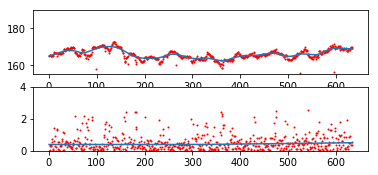

inaccurate: [77, 81, 99, 125, 156, 157, 158, 159, 160, 161, 166, 183, 231, 232, 264, 265, 303, 331, 362, 363, 376, 424, 505, 526, 535, 596, 631] 
noisy: [54, 74, 82, 89, 90, 100, 167, 180, 182, 184, 200, 230, 266, 297, 304, 360, 361, 377, 425, 429, 475, 476, 494, 506, 527, 541, 597, 632]


In [13]:
#V. Remove noisy or inaccurate channels
#RMS Differentials
noisy = []
inaccurate = []#keeps track of indicies
RMS2 = RMS.tolist() #without noisy and inaccurate channels
SEL2 = SEL#.tolist()
RMS_diff = [0]
r1 = 0
for r2 in range(1,636): #Uses relative difference to determine noisy channels
    RMS_diff.append(abs(RMS[r1]-RMS[r2]))
    r1 = r1+1
    
#local regression for RMS and RMS_diff
lowess = sm.nonparametric.lowess
b = np.linspace(0,635,636)
fit = lowess(RMS,b,is_sorted=True,return_sorted=False, frac=0.1)
fitd = lowess(RMS_diff,b,is_sorted=True,return_sorted=False,frac=1)


#Plots
plt.subplot(3,1,1)
plt.plot(b,fit)
plt.scatter(b,RMS,s=1,color='r')
plt.ylim(155,190)
plt.subplot(3,1,2)
plt.plot(b,fitd)
plt.scatter(b,RMS_diff,s=1,color='r')
plt.ylim(0,4)

#Remove bad channels

largeDelta = ((RMS2-fit)**2>=10)#innacurate
largeDelta2 = ((RMS_diff-fitd)**2>=2)#noisy

for i in range(0,636):
    if(largeDelta[i]):
        inaccurate.append(i)
        RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
    if(largeDelta2[i] and not(largeDelta[i])):
        noisy.append(i)
        RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        
        
        
        
        SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
plt.show()
print('inaccurate:',inaccurate,'\nnoisy:',noisy)


SEL180 = 12.4875
SEL160 = 12.4875
RMS180 = 12.4875
RMS160 = 12.4875


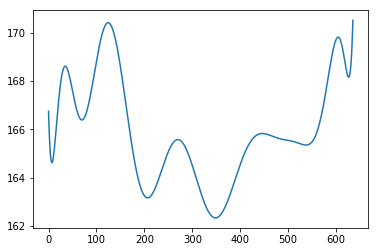

In [14]:
#VI. Fitting Data

SELmodel = np.polyfit(b, SEL2, deg=15)
RMSmodel = np.polyfit(b, RMS2, deg=15)

SELpol = np.poly1d(SELmodel) 
RMSpol = np.poly1d(RMSmodel)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,1000):
    #print(SELpol(i))
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)#Safety radii
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

plt.plot(b,RMSpol(b))
plt.show()